<div style="text-align: center; font-family: 'Arial', sans-serif;">
    <h1 style="color: #2c3e50;">Security and Privacy in Machine Learning</h1>
    <h3 style="color: #34495e;">Course Code: 40816</h3>
    <h3 style="color: #7f8c8d;">Instructor: Dr. Amir Mahdi Sadeghzadeh</h3>
    <h3 style="color: #95a5a6;">Sharif University of Technology, Iran</h3>
    <h3 style="color: #bdc3c7;">CE Department, Fall 2024</h3>
    <h3 style="color: #d35400;">Computer Assignment 5</h3>
    <h4 style="color: #e67e22;">Topic: Differential Privacy</h4>
</div>


<div style="text-align: left; font-family: 'Arial', sans-serif; font-size: 14px;">
    <h2 style="color: #3498db;">Introduction</h2>
    <p>This notebook contains the implementation for Computer Assignment 5 on Differential Privacy. Follow the instructions carefully and ensure your code adheres to the provided guidelines.</p>
</div>


<div style="text-align: left; font-family: 'Arial', sans-serif; font-size: 14px;">
    <h2 style="color: #9b59b6;">Personal Data</h2>
    <p>Please enter your student number, first name, and last name in the following cell.</p>
</div>

In [1]:
# Enter your personal details below
student_number = "402212269"  # Replace with your student number
first_name = "Amir Mohammad"      # Replace with your first name
last_name = "Ezzati"       # Replace with your last name

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h1 style="color: #2c3e50;">Part 0: Introduction to Differential Privacy</h1>
</div>

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #34495e;">Question 0: Differential Privacy Definitions (5 Points)</h2>
</div>

Provide a brief summary of Differential Privacy principles. Define $\epsilon$-differential privacy and explain its significance in protecting individual data privacy.


<div style="text-align: font-family: 'Arial', sans-serif;">
    <h1 style="color: #2c3e50;">Part 1: Mechanisms for Differential Privacy</h1>

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml # need sklearn >= 0.22
import scipy as sp
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.datasets import make_classification

Below we provide a helper function to draw bar plots from pandas Series.

In [3]:
def bar_plot_pandas(series1, series2=None, label1="Series 1", label2="Series 2", title=""):
    '''
    Draws a bar plot of one Pandas Series, or two pandas Series with the same index

    Parameters
    ----------
    series1 : Series of float
        First input
    series2 : Series of float, optional
        Second input (with same index)
    label1 : string, optional
        Label for the first series
    label2 : string, optional
        Label for the second series
    title : string, optional
        Plot title
    '''
    if series2 is None:
        series1.plot.bar()
        plt.xlabel("Index")
        plt.ylabel("Values")
        plt.title(title if title else "Bar Plot")
        plt.legend([label1])
        plt.show()
    else:
        concat_series = pd.DataFrame({label1: series1, label2: series2}).reset_index()
        concat_series["index"] = concat_series.index
        concat_series.plot.bar(x="index", y=[label1, label2], xlabel="", title=title)
        plt.xlabel("Index")
        plt.ylabel("Values")
        plt.title(title if title else "Comparison Bar Plot")
        plt.legend([label1, label2])
        plt.show()

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Dataset</h2>
</div>

We will be working with a dataset from the US Census (also known as the Adult dataset). You can read about the dataset [here](https://archive.ics.uci.edu/ml/datasets/census+income).

The following line loads the dataset from [OpenML](https://www.openml.org/) with the `fetch_openml` method of `sklearn`. The option `as_frame=True` (**requires sklearn version >= 0.22**) loads the dataset in `pandas DataFrame` format: this keeps the attributes in their original form and will be more convenient to work with. If you prefer working with a numpy array (not recommended), set `as_frame=False`.

In [38]:
# Fetching the Adult dataset from OpenML
# dataset_handle = fetch_openml(name='adult', version=2, as_frame=True)
# dataset = dataset_handle.frame

# fetch_openml didn't work when i did this homework so I downloaded csv file of this dataset and read it with pandas.
import gdown

adult_file_url = "https://drive.google.com/uc?id=12HBGtrXouBN5Yi7uyUApR5rvb25wplye"
output_path = "dataset.csv"
gdown.download(adult_file_url, output_path, quiet=False)

dataset = pd.read_csv(output_path)
dataset = dataset.iloc[:, 1:]

Downloading...
From: https://drive.google.com/uc?id=12HBGtrXouBN5Yi7uyUApR5rvb25wplye
To: /content/dataset.csv
100%|██████████| 5.55M/5.55M [00:00<00:00, 161MB/s]


Take a look at the dataset, in particular the number of rows (individuals), the number of columns (attributes) and what they represent.

In [5]:
# Exploring the dataset
n, d = dataset.shape  # Number of rows and columns
print(f"Dataset contains {n} rows (individuals) and {d} columns (attributes).")
print("\nPreview of the dataset:")
print(dataset.head(4))

Dataset contains 48842 rows (individuals) and 15 columns (attributes).

Preview of the dataset:
   age  workclass  fnlwgt     education  education-num      marital-status  \
0   25    Private  226802          11th              7       Never-married   
1   38    Private   89814       HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm             12  Married-civ-spouse   
3   44    Private  160323  Some-college             10  Married-civ-spouse   

          occupation relationship   race   sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black  Male             0             0   
1    Farming-fishing      Husband  White  Male             0             0   
2    Protective-serv      Husband  White  Male             0             0   
3  Machine-op-inspct      Husband  Black  Male          7688             0   

   hours-per-week native-country  class  
0              40  United-States  <=50K  
1              50  United-States  <=50

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 1 (non-private queries) (7 Points)</h2>
</div>

Implement a function for each of these types of queries (without privacy) and test them on the dataset:
- **Simple count queries**: it takes as input a dataset (`DataFrame`), a categorical attribute (e.g., `"sex"`) and a value (e.g., `"Male"`), and returns how many rows in the dataset have the prescribed attribute value.
- **Averaging queries**: it takes as input a dataset and a numeric attribute (e.g., `"age"`), and returns the average value of this attribute in the dataset.
- **Histogram queries**: it takes as input a dataset and a categorical attribute (e.g., `"sex"`), and returns the histogram of counts for this attribute in the dataset (i.e., for each possible value of the attribute, how many rows have this value).

Reminder: for a DataFrame `df`, we can access the column corresponding to an attribute `attr` by `df[attr]`. The method `value_counts()` allows to build a histogram of a column. To plot a pandas Series `s` as a histogram, you can use `s.plot.bar()`.

Note: You can use the function `bar_plot_pandas` provided in the preamble to draw a bar plot of a pandas Series, which is useful to show histograms.

In [6]:
def count_query(df, attribute, value):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with categorical values
    value : string or int
        Value of attribute to count

    Returns
    -------
    count : int
        The number of records with `attribute=value` in dataset `df`
    '''

    # TO COMPLETE
    count = df[df[attribute] == value].shape[0]
    return count

In [7]:
def average_query(df, attribute):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with numeric values

    Returns
    -------
    average : float
        The average value of `attribute` in dataset `df`
    '''

    # TO COMPLETE
    average = df[attribute].mean()
    return average

In [8]:
def histogram_query(df, attribute):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with categorical values

    Returns
    -------
    histogram : array or Series of int
        The histogram of `attribute`, i.e., the number of times each value of `attribute` appears in `df`
    '''
    # TO COMPLETE
    histogram = df[attribute].value_counts()
    return histogram

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 2 (Laplace mechanism) (10 Points)</h2>
</div>

Implement the Laplace mechanism, i.e., a function which takes as input a (non-private) query output, the query's $\ell_1$ sensitivity, the desired value of $\epsilon$ and a random seed (for reproducibility), and returns a $\epsilon$-differentially private estimate of the query. To draw Laplace noise, check `np.random.laplace`. The function should work with queries that output a scalar (like simple count and averaging queries), as well as those that output a vector (like histogram queries).

In [9]:
def laplace_mechanism(q, s1, eps, random_state=None):
    '''
    Parameters
    ----------
    q : float or array/Series of float
        The non-private output of the query
    s1 : float
        The L1 sensitivity of the query
    eps : float
        Parameter epsilon of differential privacy
    random_state : int, optional (default=None)
        Random seed

    Returns
    -------
    private_q : float or array/Series of float
        An eps-DP evaluation of the query
    '''

    rng = np.random.RandomState(random_state)

    # TO COMPLETE
    if hasattr(q, 'shape'): # query output is multi-dimensional
        noise = rng.laplace(loc=0, scale=s1/eps, size=q.shape)
        private_q = q + noise

    else: # query output is a scalar
        noise = rng.laplace(loc=0, scale=s1/eps)
        private_q = q + noise

    return private_q



In [10]:
histogram_query(dataset, 'occupation')

,count
occupation,
Prof-specialty,6172
Craft-repair,6112
Exec-managerial,6086
Adm-clerical,5611
Sales,5504
Other-service,4923
Machine-op-inspct,3022
Transport-moving,2355
Handlers-cleaners,2072


In [20]:
laplace_mechanism(histogram_query(dataset, 'occupation'), s1=1, eps=1, random_state=42)

,count
occupation,
Prof-specialty,6171.711091
Craft-repair,6114.316974
Exec-managerial,6086.623599
Adm-clerical,5611.219795
Sales,5502.835367
Other-service,4921.835213
Machine-op-inspct,3019.847275
Transport-moving,2356.318084
Handlers-cleaners,2072.225935


<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 3 (Laplace mechanism on count queries) (8 Points)</h2>
</div>

We would like to use the Laplace mechanism to:
- privately count the number of males in the dataset
- generate a private histogram of the `"workclass"` attribute

What is the sensitivity of the query in each case?

Run the Laplace mechanism with different values of $\epsilon$ and compute the $\ell_1$-error with respect to the true (non-private) output to see the effect on the utility and compare with the formal error bound seen in the lecture. Recall that the mechanism is random, so unless you fix the seed you will get a different result at each execution. Visually compare the private and non-private histograms using the function `bar_plot_pandas` provided at the beginning of the notebook.

Note: you may round the outputs of the private mechanism to make them integers if you like. This can be considered as post-processing and thus preserves DP (see Bonus Question 5 to go further on this aspect).


Epsilon: 0.001
Query: int, L1 Error: 288.91
Non-private: 32650, Private: 32361.09082522566
----------------------------------------------------------------------------------------------------

Epsilon: 0.001
Query: Series, L1 Error: 17963.73


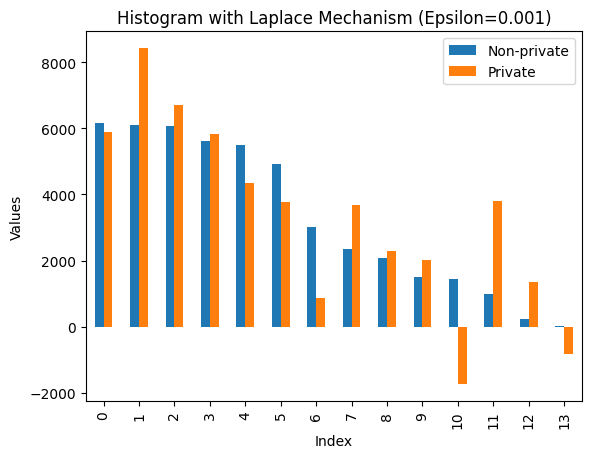

----------------------------------------------------------------------------------------------------

Epsilon: 0.01
Query: int, L1 Error: 28.89
Non-private: 32650, Private: 32621.109082522566
----------------------------------------------------------------------------------------------------

Epsilon: 0.01
Query: Series, L1 Error: 1796.37


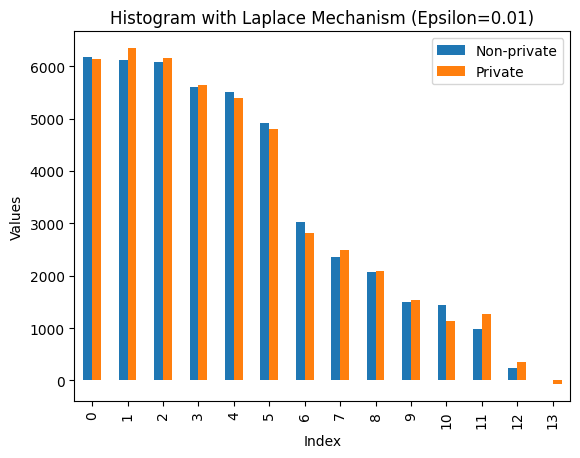

----------------------------------------------------------------------------------------------------

Epsilon: 0.1
Query: int, L1 Error: 2.89
Non-private: 32650, Private: 32647.110908252256
----------------------------------------------------------------------------------------------------

Epsilon: 0.1
Query: Series, L1 Error: 179.64


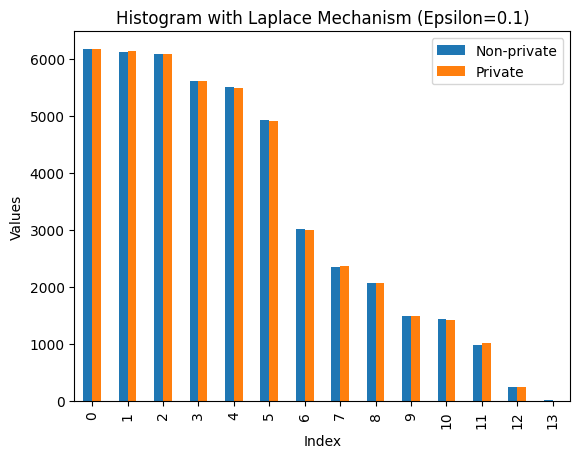

----------------------------------------------------------------------------------------------------

Epsilon: 1.0
Query: int, L1 Error: 0.29
Non-private: 32650, Private: 32649.711090825225
----------------------------------------------------------------------------------------------------

Epsilon: 1.0
Query: Series, L1 Error: 17.96


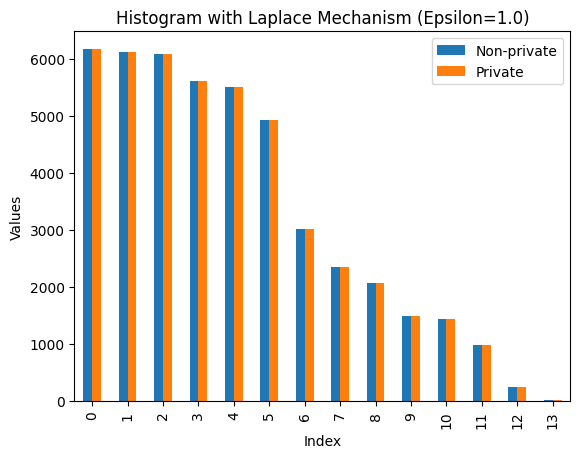

----------------------------------------------------------------------------------------------------

Epsilon: 10
Query: int, L1 Error: 0.03
Non-private: 32650, Private: 32649.971109082522
----------------------------------------------------------------------------------------------------

Epsilon: 10
Query: Series, L1 Error: 1.80


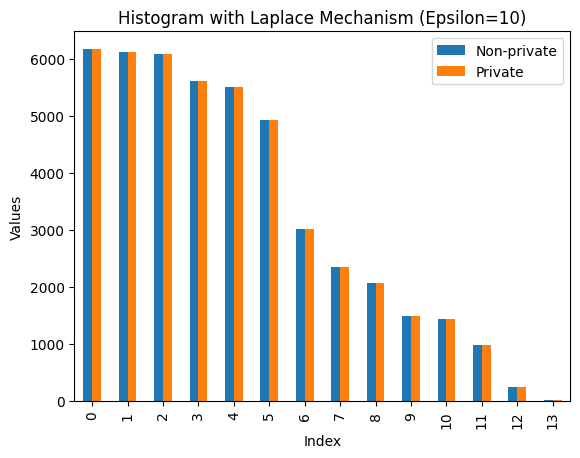

----------------------------------------------------------------------------------------------------


In [21]:
def l1_error(a, b):
    '''
    Parameters
    ----------
    a : float or array/Series of float
        First input
    b : float or array/Series of float
        Second input

    Returns
    -------
    l1_error : float
        The L1 distance between `a` and `b`: ||a-b||_1
    '''

    # TO COMPLETE
    if np.isscalar(a) and np.isscalar(b):  # If both inputs are scalars
        return abs(a - b)
    else:  # If inputs are arrays or Series
        return np.linalg.norm(np.array(a) - np.array(b), ord=1)


# list of (query,sensitivity) tuples to loop over
queries = [
    (count_query(dataset, "sex", "Male"), 1),  # Query: count males, Sensitivity: 1
    (histogram_query(dataset, "occupation"), 1)  # Query: histogram of workclass, Sensitivity: 1
]

# Values of epsilon
epsilons = [0.001, 0.01, 0.1, 1.0, 10]

for eps in epsilons:
    for query, sensitivity in queries:
        print(f"\nEpsilon: {eps}")
        private_query = laplace_mechanism(query, sensitivity, eps, random_state=42)

        error = l1_error(private_query, query)
        print(f"Query: {type(query).__name__}, L1 Error: {error:.2f}")

        # If the query is a histogram, visualize the results
        if hasattr(query, 'shape') or isinstance(query, pd.Series):
            bar_plot_pandas(
                query, private_query,
                label1="Non-private", label2="Private",
                title=f"Histogram with Laplace Mechanism (Epsilon={eps})"
            )
            print('-'*100)
        else:
            print(f"Non-private: {query}, Private: {private_query}")
            print('-'*100)


<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 4 (Gaussian mechanism and comparison with Laplace) (12 Points)</h2>
</div>

Implement the Gaussian mechanism (to draw Gaussian noise, check `np.random.normal`). Make an experimental comparison with the Laplace mechanism by plotting the privacy-utility trade-off for a 1D query of your choice. For the Gaussian mechanism, study the influence of $\delta$.

In [22]:
def gaussian_mechanism(q, s2, eps, delta, random_state=None):
    '''
    Parameters
    ----------
    q : float or array/Series of float
        The non-private output of the query
    s2 : float
        The L2 sensitivity of the query
    eps : float
        Parameter epsilon of differential privacy
    delta : float
        Parameter delta of differential privacy
    random_state : int, optional (default=None)
        Random seed

    Returns
    -------
    private_q : float or array/Series of float
        An (eps,delta)-DP evaluation of the query
    '''

    rng = np.random.RandomState(random_state)

    # TO COMPLETE
    if hasattr(q, 'shape'): # query output is multi-dimensionale
        sigma = np.sqrt(2*np.log(1.25/delta))*s2/eps
        y = rng.normal(0, sigma, q.shape)
    else: # query output is a scalar
        sigma = np.sqrt(2*np.log(1.25/delta))*s2/eps
        y = rng.normal(0, sigma, 1)

    private_q = q + y

    return private_q

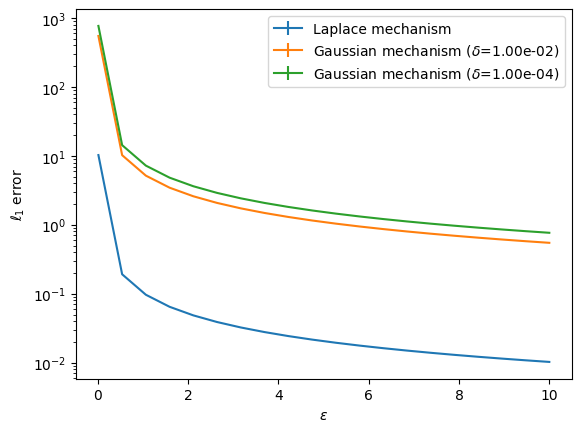

In [23]:
q = count_query(dataset, "sex", "Male")
s = 1
eps_list = np.linspace(0.01, 10.0, num=20)
delta1 = 1. / 10**2
delta2 = 1. / 10**4
n_runs = 50

error = np.zeros((len(eps_list), 3, n_runs))

for i, eps in enumerate(eps_list):
    for r in range(n_runs):
        # Laplace mechanism
        q_laplace = laplace_mechanism(q, s, eps, random_state=0)
        error[i, 0, r] = l1_error(q, q_laplace)

        # Gaussian mechanism with delta1
        q_gaussian1 = gaussian_mechanism(q, s, eps, delta1, random_state=0)
        error[i, 1, r] = l1_error(q, q_gaussian1)

        # Gaussian mechanism with delta2
        q_gaussian2 = gaussian_mechanism(q, s, eps, delta2, random_state=0)
        error[i, 2, r] = l1_error(q, q_gaussian2)


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(eps_list, error[:, 0, :].mean(axis=1), error[:, 0, :].std(axis=1), label='Laplace mechanism')
ax.errorbar(eps_list, error[:, 1, :].mean(axis=1), error[:, 1, :].std(axis=1),
            label='Gaussian mechanism ($\delta$=' + "{:.2e}".format(delta1) + ')')
ax.errorbar(eps_list, error[:, 2, :].mean(axis=1), error[:, 2, :].std(axis=1),
            label='Gaussian mechanism ($\delta$=' + "{:.2e}".format(delta2) + ')')
plt.xlabel("$\epsilon$")
plt.ylabel("$\ell_1$ error")
ax.set_yscale('log')
ax.legend()
plt.show()

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h1 style="color: #2c3e50;">Part 3: Applications of Differential Privacy</h1>
</div>

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 5 (contingency tables and the "paradox" of parallel composition) (8 Points)</h2>
</div>

We can go beyond histograms and build contingency tables across two (or even more) variables. Implement a function for such queries using `crosstab` from pandas, and use the Laplace mechanism to privately find out how people in the dataset break down according to the combination of `'gender'` and `'marital-status'`. You may need to adapt your implementation of Laplace to work with k-way tables (e.g., by using the method `applymap` together with a function that adds 1D Laplace noise).

Pushing this reasoning further, it may seem that there is a paradox because parallel composition gets us more information "for free" (e.g., we can build a k-way table over a large number of attributes that could ultimately reveal very precise information about individuals in the dataset, without increasing the privacy loss). This contradicts the principle that asking more things should cost something. Explain why there is in fact no paradox and what is the cost that one pays in this case (if needed, you can see what happens when privately releasing contingency tables across many columns).

In [24]:
def table_query(df, row_attr_list, col_attr_list):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    row_attr_list : list
        List of attributes
    col_attr_list : list
        List of attributes

    Returns
    -------
    cross_table : DataFrame
        Cross tabulation (contingency table) of `df` according to `row_attr_list` and `col_attr_list`
    '''

    # TO COMPLETE
    cross_table = pd.crosstab(index=[df[attr] for attr in row_attr_list],
                              columns=[df[attr] for attr in col_attr_list])

    # Add Laplace noise to each cell
    rng = np.random.RandomState(0)
    sensitivity = 1
    scale = sensitivity / 0.1  # Scale for Laplace noise

    private_cross_table = cross_table.applymap(lambda x: x + rng.laplace(scale=scale))

    return private_cross_table

In [25]:
# Private contingency table
private_table = table_query(
    dataset,
    row_attr_list=['sex'],
    col_attr_list=['marital-status']
)

print("Differentially private contingency table:\n", private_table)

Differentially private contingency table:
 marital-status     Divorced  Married-AF-spouse  Married-civ-spouse  \
sex                                                                  
Female          4002.027273           27.30076         2478.343109   
Male            2637.627836           12.94054        19902.450121   

marital-status  Married-spouse-absent  Never-married   Separated      Widowed  
sex                                                                            
Female                     302.666679     7244.21765  939.757490  1234.462857  
Male                       339.303772     8896.34579  599.595269   304.051070  


<ipython-input-24-f1cb110b447d>:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  private_cross_table = cross_table.applymap(lambda x: x + rng.laplace(scale=scale))


<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 6 (Laplace mechanism on average queries) (9 Points)</h2>
</div>

We would like to use the Laplace mechanism to privately estimate the average age of people in the dataset. We assume that the number of people in the dataset is public.

1. Propose and implement simple practical strategies to compute or estimate the sensitivity of this query in the following two scenarios, and discuss the merits and/or drawbacks of your proposals:
  - You are the trusted curator: you have access to the raw dataset and would like to release an estimate of the average age of people in the dataset with differential privacy guarantees.
  - You are an external data analyst: you do not have access to the raw dataset but only to an API to send queries. You have to convince the trusted curator that the proposed sensitivity is safe.
2. Suggest some ideas regarding how we could change a bit the query to get a simple and safe bound on sensitivity, at the expense of possibly introducing some bias in the output. Implement the proposed solution. Hint: the method `clip` from pandas might be useful here.

**Answer:**

**Q1**
Trusted Curator:
As a trusted curator, we can **use the actual minimum and maximum ages** in the dataset to compute sensitivity:

$
\text{sensitivity} = \frac{\text{max age} - \text{min age}}{n}
$

**Q1** External Analyst:
As an external analyst without access to raw data, we can **assume most people live up to 100 years** based on public mortality data. Sensitivity can then be approximated as:  

$
\text{sensitivity} = \frac{100 - 0}{n}
$

**Q2**
Clipping:
By **clipping ages** to the range 20–80, we can consistently use the sensitivity:  
$
\text{sensitivity} = \frac{80 - 20}{n}
$

This method reduces the impact of outliers while ensuring privacy, though it may introduce slight bias.

In [26]:
# Trusted Curator Approach (Using actual min and max from data)

ages = dataset["age"]
n = len(ages)

min_age, max_age = ages.min(), ages.max()
sensitivity_curator = (max_age - min_age) / n
private_avg_curator = laplace_mechanism(average_query(dataset, 'age'), s1=sensitivity_curator, eps=0.01, random_state=42)

private_avg_curator, min_age, max_age, n

(38.60040463175437, 17, 90, 48842)

In [14]:
# External Analyst Approach (Assuming ages are between 0 and 100)
n = len(dataset)
sensitivity_analyst = (100 - 0) / n
private_avg_analyst = laplace_mechanism(average_query(dataset, 'age'), s1=sensitivity_analyst, eps=0.01, random_state=42)

private_avg_analyst

38.5844336483407

In [15]:
# Clipping Ages to Range 20–80
MAX_AGE = 80
MIN_AGE = 20

dataset_clipped_clipping = dataset.copy()
dataset_clipped_clipping["age"] = dataset_clipped_clipping["age"].clip(lower=MIN_AGE, upper=MAX_AGE)
n = len(dataset_clipped_clipping)

sensitivity_clipping = (MAX_AGE - MIN_AGE) / n
private_avg_clipping = laplace_mechanism(average_query(dataset_clipped_clipping, 'age'), s1=sensitivity_clipping, eps=0.01, random_state=42)

private_avg_clipping

38.68470875376426

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 7 (average over a subset) (6 Points)</h2>
</div>

We would now like to compute the average age of divorced people. How can we use the Laplace mechanism to privately answer this query? Implement your solution.

In [16]:
# Actual
dataset[dataset['marital-status'] == 'Divorced']['age'].mean()

43.159203980099505

In [17]:
# Private answer
subset = dataset[dataset['marital-status'] == 'Divorced']
n_subset = len(subset)

ages = subset["age"]
min_age, max_age = ages.min(), ages.max()
sensitivity = (max_age - min_age) / n_subset

private_avg = laplace_mechanism(average_query(subset, 'age'), s1=sensitivity, eps=0.01, random_state=42)

private_avg

42.84559836297675

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 8 (non-private SGD) (17 Points)</h2>
</div>

In this question, we will implement our own simple version of SGD, as well as define our own sklearn-compatible $\ell_2$-regularized logistic regression estimator. This will be convenient when we will implement a differentially private version in Question 9.

Below, you are given several pieces of code:
1. A function `sgd` which implements SGD: it is meant to be generic in the sense that it takes as input a function `obj_and_grad` which computes the value and the gradient of the desired objective function. **This function has missing parts that you need to complete**.


2. A function `my_logistic_obj_and_grad` (adapted from [the version from sklearn](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/linear_model/_logistic.py#L84)) which computes the value and gradient of the logistic regression problem. You do not need to modify this function.


3. A class `MySGDLogisticRegression` which defines a sklearn estimator for logistic regression, where the model is fit using SGD using the previous two functions. You do not need to modify this function.

Spend a bit of time to get familiar with the code provided, then complete the missing bits in the `sgd` function. Make sure it works by trying it on the binary classification dataset that you previously loaded.

In [18]:
def sgd(X, y, gamma, n_iter, obj_and_grad, theta_init, n_batch=1, freq_obj_eval=10,
        n_obj_eval=1000, random_state=None):
    """Stochastic Gradient Descent (SGD) algorithm

    Parameters
    ----------
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1).
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    obj_and_grad : callable
        A function which takes as a vector of shape (p,), a dataset of shape (n_batch, d)
        and a label vector of shape (n_batch,), and returns the objective value and gradient.
    theta_init : array, shape (p,)
        The initial value for the model parameters
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objective
    random_state : int
        Random seed to make the algorithm deterministic


    Returns
    -------
    theta : array, shape=(p,)
        The final value of the model parameters
    obj_list : list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_obj_eval iterations
    """

    rng = np.random.RandomState(random_state)
    n, d = X.shape
    p = theta_init.shape[0]

    theta = theta_init.copy()

    # if a constant step size was provided, we turn it into a constant function
    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    # list to record the evolution of the objective (for plotting)
    obj_list = []
    # we draw a fixed subset of points to monitor the objective
    idx_eval = rng.randint(0, n, n_obj_eval)

    for t in range(n_iter):
        if t % freq_obj_eval == 0:
            # evaluate objective
            obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])
            obj_list.append(obj)

        # TO COMPLETE
        for i in range(n // n_batch):
            obj, grad = obj_and_grad(theta, X[i * n_batch : (i+1) * n_batch , :], y[i * n_batch : (i+1) * n_batch])
            theta = theta - gamma_func(t) * grad
            print(f"Step #{t} | Batch #{i} | obj = {obj}", end='\r')

    return theta, obj_list

In [92]:
from sklearn.linear_model._base import LinearClassifierMixin, SparseCoefMixin, BaseEstimator
from sklearn.utils.extmath import safe_sparse_dot
from scipy.special import expit
from sklearn.utils.validation import check_X_y

def _intercept_dot(theta, X, y):
    """
    Compute the dot product of X and coef, adding the intercept if present.
    Parameters
    ----------
    theta : array, shape (d,) or (d+1,)
        Model parameters including coefficients and optional intercept.
    X : array, shape (n_samples, n_features)
        Feature matrix.
    y : array, shape (n_samples,)
        Labels (-1, 1).

    Returns
    -------
    w : array, shape (d,)
        Coefficients (excluding the intercept).
    c : float
        Intercept.
    yz : array, shape (n_samples,)
        Product of y and (X @ w + c).
    """
    n_features = X.shape[1]
    w = theta[:n_features]
    c = theta[n_features] if theta.shape[0] > n_features else 0.0
    yz = y * (np.dot(X, w) + c)
    return w, c, yz

def log_logistic(x):
    """
    Compute the log of the logistic function.
    Parameters
    ----------
    x : array, shape (n_samples,)
        Input values.

    Returns
    -------
    log_logistic_values : array, shape (n_samples,)
        Log-logistic values.
    """
    return -np.logaddexp(0, -x)


def my_logistic_obj_and_grad(theta, X, y, lamb):
    """Computes the value and gradient of the objective function of logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = w (if no intercept), or theta = [w b] (if intercept)

    Parameters
    ----------
    theta_init : array, shape (d,) or (d+1,)
        The initial value for the model parameters. When an intercept is used, it corresponds to the last entry
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1)
    lamb : float
        The L2 regularization parameter


    Returns
    -------
    obj : float
        The value of the objective function
    grad : array, shape (d,) or (d+1,)
        The gradient of the objective function
    """
    n_samples, n_features = X.shape
    grad = np.empty_like(theta)

    w, c, yz = _intercept_dot(theta, X, y)

    # Logistic loss is the negative of the log of the logistic function
    obj = -np.mean(log_logistic(yz)) + .5 * lamb * np.dot(w, w)

    z = expit(yz)
    z0 = (z - 1) * y

    grad[:n_features] = safe_sparse_dot(X.T, z0) / n_samples + lamb * w

    # Case where we fit the intercept
    if grad.shape[0] > n_features:
        grad[-1] = z0.sum() / n_samples
    return obj, grad


class MySGDLogisticRegression(BaseEstimator, LinearClassifierMixin, SparseCoefMixin):
    """Our own sklearn estimator for logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = [w b]

    Parameters
    ----------
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    lamb : float
        The L2 regularization parameter
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objectuve
    random_state : int
        Random seed to make the algorithm deterministic

    Attributes
    ----------
    coef_ : (p,)
        The weights of the logistic regression model.
    intercept_ : (1,)
        The intercept term of the logistic regression model.
    obj_list_: list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_loss_eval iterations
    """

    def __init__(self, gamma, n_iter, lamb=0, n_batch=1, freq_obj_eval=10, n_obj_eval=1000, random_state=None):
        self.gamma = gamma
        self.n_iter = n_iter
        self.lamb = lamb
        self.n_batch = n_batch
        self.freq_obj_eval = freq_obj_eval
        self.n_obj_eval = n_obj_eval
        self.random_state = random_state

    def fit(self, X, y):

        # WARNING: assumes labels are -1, 1
        X, y = check_X_y(X, y, accept_sparse='csr', dtype=[np.float64, np.float32], order="C")
        self.classes_ = np.unique(y)

        p = X.shape[1]
        theta_init = np.zeros(p+1) # initialize parameters to zero
        # define the function for value and gradient needed by SGD
        obj_grad = lambda theta, X, y: my_logistic_obj_and_grad(theta, X, y, lamb=self.lamb)
        theta, obj_list = sgd(X, y, self.gamma, self.n_iter, obj_grad, theta_init, self.n_batch,
                              self.freq_obj_eval, self.n_obj_eval, self.random_state)

        # save the learned model into the appropriate quantities used by sklearn
        self.intercept_ = np.expand_dims(theta[-1], axis=0)
        self.coef_ = np.expand_dims(theta[:-1], axis=0)

        # also save list of objective values during optimization for plotting
        self.obj_list_ = obj_list

        return self

In [111]:
X, y = make_classification(n_samples=1000, n_features=14, n_informative=10,
                           n_redundant=4, n_classes=2, random_state=42)
y = np.where(y == 0, -1, 1).astype(float)


# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((800, 14), (200, 14), (800,), (200,))

Test accuracy 0.86


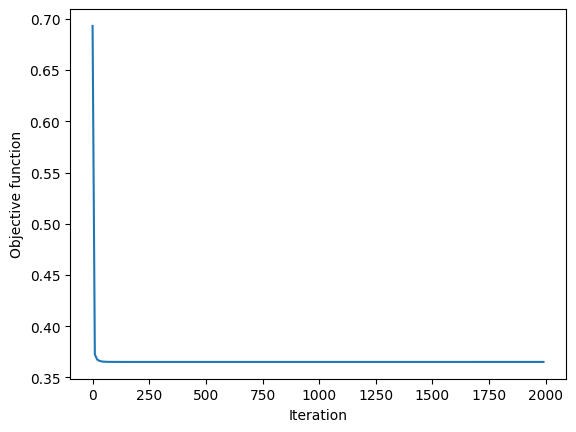

In [112]:
lamb = 0
n_iter = 2000
n_batch = 100
gamma = 0.1
# gamma = lambda t: 1 / np.sqrt(t)

mlr = MySGDLogisticRegression(gamma, n_iter, lamb, n_batch=n_batch, random_state=None)
mlr.fit(X_train, y_train)
print("Test accuracy", mlr.score(X_test, y_test))

obj_list = mlr.obj_list_
iter_list = np.arange(len(obj_list)) * mlr.freq_obj_eval
plt.plot(iter_list, obj_list)
plt.xlabel("Iteration")
plt.ylabel("Objective function")
plt.show()

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 9 (private SGD) (18 Points)</h2>
</div>

We will now implement and experiment with DP-SGD:
1. Following the model of the function `sgd`, implement a new function `private_sgd` which implements DP-SGD **with mini-batch size of 1 and no regularization**. It can take as input the desired value of $\epsilon$ and $\delta$ for the $(\epsilon,\delta)$-DP, or alternatively the standard deviation of the Gaussian noise to add at each iteration. Note: you do not need to make the objective plotting part private (this is only for monitoring).


2. Following the model of the class `MySGDLogisticRegression`, implement a new class `MyPrivateSGDLogisticRegression` which implements differentially private logistic regression trained using your DP-SGD implementation above.


3. Experiment with different values of $\epsilon$ and $\delta$, number of iterations and step size, and study the effect on the convergence of SGD as well as the test accuracy of the resulting model. Describe your observations. How should the number of iterations depend on the level of privacy? How can we choose the number of iterations and step size in practice?

In [114]:
# code

def private_sgd(X, y, gamma, n_iter, obj_and_grad, theta_init, epsilon, delta, n_batch=1, freq_obj_eval=10,
        n_obj_eval=1000, random_state=None):

    rng = np.random.RandomState(random_state)
    n, d = X.shape
    p = theta_init.shape[0]

    theta = theta_init.copy()

    # if a constant step size was provided, we turn it into a constant function
    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    # list to record the evolution of the objective (for plotting)
    obj_list = []
    # we draw a fixed subset of points to monitor the objective
    idx_eval = rng.randint(0, n, n_obj_eval)

    for t in range(n_iter):
        if t % freq_obj_eval == 0:
            # evaluate objective
            obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])
            obj_list.append(obj)

        for i in range(n // n_batch):
            obj, grad = obj_and_grad(theta, X[i * n_batch : (i+1) * n_batch , :], y[i * n_batch : (i+1) * n_batch])

            sigma = 16 * np.sqrt(n_iter * np.log(2/delta) * np.log(2.5*n_iter/(delta*n))) / (n * epsilon)
            noise = rng.normal(0, sigma, p)

            theta = theta - gamma_func(t) * grad + noise
            print(f"Step #{t} | Batch #{i} | obj = {obj}", end='\r')

    return theta, obj_list


In [115]:
class MyPrivateSGDLogisticRegression(BaseEstimator, LinearClassifierMixin, SparseCoefMixin):

    def __init__(self, gamma, n_iter, epsilon, delta, lamb=0, n_batch=1, freq_obj_eval=10, n_obj_eval=1000, random_state=None):
        self.gamma = gamma
        self.n_iter = n_iter
        self.lamb = lamb
        self.n_batch = n_batch
        self.freq_obj_eval = freq_obj_eval
        self.n_obj_eval = n_obj_eval
        self.random_state = random_state

        self.epsilon = epsilon
        self.delta = delta

    def fit(self, X, y):

        # WARNING: assumes labels are -1, 1
        X, y = check_X_y(X, y, accept_sparse='csr', dtype=[np.float64, np.float32], order="C")
        self.classes_ = np.unique(y)

        p = X.shape[1]
        theta_init = np.zeros(p+1) # initialize parameters to zero
        # define the function for value and gradient needed by SGD
        obj_grad = lambda theta, X, y: my_logistic_obj_and_grad(theta, X, y, lamb=self.lamb)
        theta, obj_list = private_sgd(X, y, self.gamma, self.n_iter, obj_grad, theta_init, self.epsilon, self.delta, self.n_batch,
                              self.freq_obj_eval, self.n_obj_eval, self.random_state)

        # save the learned model into the appropriate quantities used by sklearn
        self.intercept_ = np.expand_dims(theta[-1], axis=0)
        self.coef_ = np.expand_dims(theta[:-1], axis=0)

        # also save list of objective values during optimization for plotting
        self.obj_list_ = obj_list

        return self

In [158]:
def experiment(n_iter, gamma):
    n = X_train.shape[0]

    eps_list = [0.1, 1, 5, 10]
    delta_list = [1. / n**2, 1. / n**4]
    n_runs = 4

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    accuracy = np.zeros((len(eps_list), len(delta_list), n_runs))
    for j, delta in enumerate(delta_list):
        for i, eps in enumerate(eps_list):
            for r in range(n_runs):
                print(f"delta = {delta} | epsilon = {eps} | run {r}\n", end = '\r')
                mdplr = MyPrivateSGDLogisticRegression(gamma, n_iter, epsilon=eps, delta=delta, lamb=lamb, n_batch=n_batch, random_state=None)
                mdplr.fit(X_train, y_train)
                accuracy[i, j, r] = mdplr.score(X_test, y_test)


        ax.errorbar(eps_list, accuracy[:, j, :].mean(axis=1), accuracy[:, j, :].std(axis=1),
                        label='DP-SGD ($\delta$=' + "{:.2e}".format(delta) + ')')

    ax.set_xticks(eps_list)
    ax.set_xticklabels([f"{eps:.1f}" for eps in eps_list])

    plt.xlabel("$\epsilon$")
    plt.ylabel("Accuracy")
    ax.legend()

delta = 1.5625e-06 | epsilon = 0.1 | run 0
delta = 1.5625e-06 | epsilon = 0.1 | run 1
delta = 1.5625e-06 | epsilon = 0.1 | run 2
delta = 1.5625e-06 | epsilon = 0.1 | run 3
delta = 1.5625e-06 | epsilon = 1 | run 0
delta = 1.5625e-06 | epsilon = 1 | run 1
delta = 1.5625e-06 | epsilon = 1 | run 2
delta = 1.5625e-06 | epsilon = 1 | run 3
delta = 1.5625e-06 | epsilon = 5 | run 0
delta = 1.5625e-06 | epsilon = 5 | run 1
delta = 1.5625e-06 | epsilon = 5 | run 2
delta = 1.5625e-06 | epsilon = 5 | run 3
delta = 1.5625e-06 | epsilon = 10 | run 0
delta = 1.5625e-06 | epsilon = 10 | run 1
delta = 1.5625e-06 | epsilon = 10 | run 2
delta = 1.5625e-06 | epsilon = 10 | run 3
delta = 2.44140625e-12 | epsilon = 0.1 | run 0
delta = 2.44140625e-12 | epsilon = 0.1 | run 1
delta = 2.44140625e-12 | epsilon = 0.1 | run 2
delta = 2.44140625e-12 | epsilon = 0.1 | run 3
delta = 2.44140625e-12 | epsilon = 1 | run 0
delta = 2.44140625e-12 | epsilon = 1 | run 1
delta = 2.44140625e-12 | epsilon = 1 | run 2
delta = 2

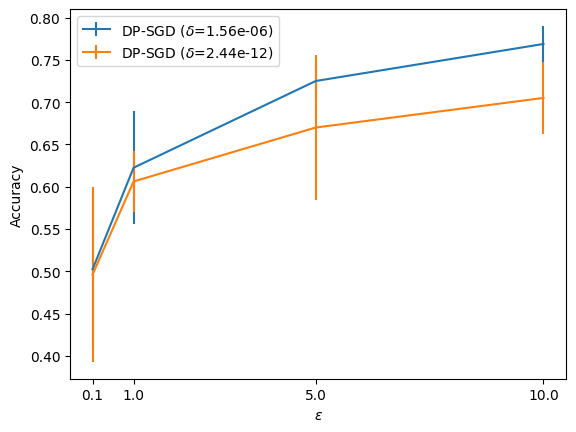

In [139]:
# test different epsilon and delta
lamb = 0
n_iter = 200
n_batch = 100
gamma = 0.1

experiment(n_iter, gamma)

**As expected, stricter privacy settings with lower ϵ and δ result in increased noise during gradient descent, which in turn leads to a reduction in accuracy.**

delta = 1.5625e-06 | epsilon = 0.1 | run 0
delta = 1.5625e-06 | epsilon = 0.1 | run 1
delta = 1.5625e-06 | epsilon = 0.1 | run 2
delta = 1.5625e-06 | epsilon = 0.1 | run 3
delta = 1.5625e-06 | epsilon = 1 | run 0
delta = 1.5625e-06 | epsilon = 1 | run 1
delta = 1.5625e-06 | epsilon = 1 | run 2
delta = 1.5625e-06 | epsilon = 1 | run 3
delta = 1.5625e-06 | epsilon = 5 | run 0
delta = 1.5625e-06 | epsilon = 5 | run 1
delta = 1.5625e-06 | epsilon = 5 | run 2
delta = 1.5625e-06 | epsilon = 5 | run 3
delta = 1.5625e-06 | epsilon = 10 | run 0
delta = 1.5625e-06 | epsilon = 10 | run 1
delta = 1.5625e-06 | epsilon = 10 | run 2
delta = 1.5625e-06 | epsilon = 10 | run 3
delta = 2.44140625e-12 | epsilon = 0.1 | run 0
delta = 2.44140625e-12 | epsilon = 0.1 | run 1
delta = 2.44140625e-12 | epsilon = 0.1 | run 2
delta = 2.44140625e-12 | epsilon = 0.1 | run 3
delta = 2.44140625e-12 | epsilon = 1 | run 0
delta = 2.44140625e-12 | epsilon = 1 | run 1
delta = 2.44140625e-12 | epsilon = 1 | run 2
delta = 2

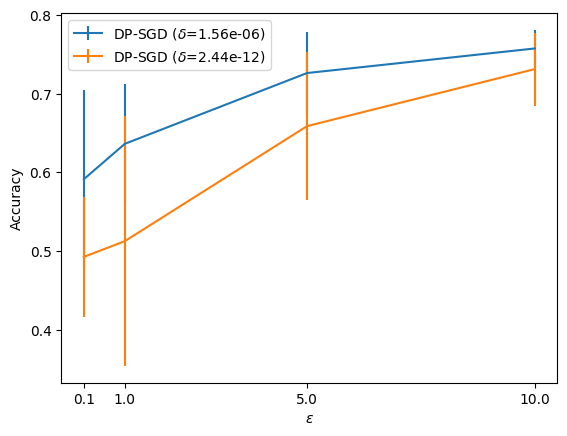

In [161]:
# test more interations
lamb = 0
n_iter = 1000
n_batch = 100
gamma = 0.1

experiment(n_iter, gamma)

**With an increased number of iterations, accuracy improves slightly for lower values of ϵ and δ, and it may also result in strong overall performance.**


delta = 1.5625e-06 | epsilon = 0.1 | run 0
delta = 1.5625e-06 | epsilon = 0.1 | run 1
delta = 1.5625e-06 | epsilon = 0.1 | run 2
delta = 1.5625e-06 | epsilon = 0.1 | run 3
delta = 1.5625e-06 | epsilon = 1 | run 0
delta = 1.5625e-06 | epsilon = 1 | run 1
delta = 1.5625e-06 | epsilon = 1 | run 2
delta = 1.5625e-06 | epsilon = 1 | run 3
delta = 1.5625e-06 | epsilon = 5 | run 0
delta = 1.5625e-06 | epsilon = 5 | run 1
delta = 1.5625e-06 | epsilon = 5 | run 2
delta = 1.5625e-06 | epsilon = 5 | run 3
delta = 1.5625e-06 | epsilon = 10 | run 0
delta = 1.5625e-06 | epsilon = 10 | run 1
delta = 1.5625e-06 | epsilon = 10 | run 2
delta = 1.5625e-06 | epsilon = 10 | run 3
delta = 2.44140625e-12 | epsilon = 0.1 | run 0
delta = 2.44140625e-12 | epsilon = 0.1 | run 1
delta = 2.44140625e-12 | epsilon = 0.1 | run 2
delta = 2.44140625e-12 | epsilon = 0.1 | run 3
delta = 2.44140625e-12 | epsilon = 1 | run 0
delta = 2.44140625e-12 | epsilon = 1 | run 1
delta = 2.44140625e-12 | epsilon = 1 | run 2
delta = 2

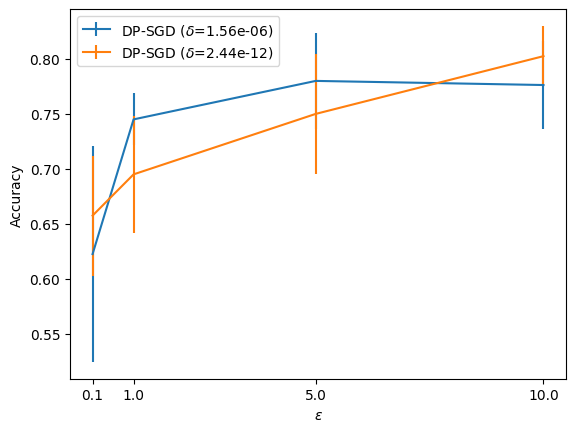

In [148]:
# test different gamma(step size)
lamb = 0
n_iter = 200
n_batch = 100
gamma = 0.5

experiment(n_iter, gamma)

**As the step size increases, the standard deviation of runs for a specific ϵ and δ also increases, while a smaller step size helps with more convergence.**

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Optional: Question 10 (federated learning with DP: DP-SGD in the distributed model) (20 Points)</h2>
</div>

Enough with these simple queries! Let's train a machine learning model in the federated learning, in which $n$ participants with their own datasets collaborate to train a joint model. Each participant $i$ wants to ensure that the algorithm satisfies $(\epsilon,\delta)$-DP with respect to his/her own dataset $D_i$. This is sometimes referred to as the distributed model of DP. Note that if each participant has a dataset of size 1 then this is exactly local DP. However, the privacy-utility trade-off will be better when participants have more data points, which is what we consider below.

The following code loads the US Census dataset in one-hot encoded version. Feel free to use another binary classification dataset of your choice instead.

In [ ]:
X, y = fetch_openml(name='a9a', version=1, return_X_y=True, as_frame=False)
normalizer = Normalizer()
X = normalizer.transform(X)
m, d = X.shape
print(m, d)

Consider a setting with $n=5$ participants. To simulate the federated learning setting, we will split the dataset in $n$ local datasets of roughly equal size. To do this, we use `sklearn.model_selection.KFold`.

In [ ]:
n = 5
features = {}
labels = {}
for i, idx in enumerate(KFold(n_splits=n, shuffle=True).split(X)):
    features[i] = X[idx[1],:]
    labels[i] = y[idx[1]]

for i in range(n):
    print("Dataset of participant " + str(i) + ":", features[i].shape, labels[i].shape)

We would now like to train a logistic regression classifier with DP-SGD in the federated setting. For simplicity of exposition, assume the presence of an *untrusted* aggregator. The algorithm follows an interative process, where each iteration consists of the following steps:
1. The trusted aggregator sends the current parameters of the model to the participants.

2. Each participant $i$ computes a stochastic gradient using a mini-batch from his local dataset $D_i$, adds Gaussian noise locally to ensure DP, and sends it to the untrusted aggregator.

3. The untrusted aggregator averages these gradients and use the result to update the model with a gradient step.

How much Gaussian noise should each participant add at each iteration to ensure an $(\epsilon,\delta)$-DP guarantee for the entire algorithm?

Adapt your centralized DP-SGD code from the previous practical to simulate this federated learning version. Compare the utility with the centralized version, studying in particular the effect of the number of participants.

Suppose that the local dataset sizes are imbalanced across participants. How does this affect the Gaussian noise added by each participant? How does this effect the utility? Suggest an appropriate weighted aggregation scheme to mitigate this.